In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

%matplotlib inline

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 300

print('Batch size:', BATCH_SIZE)

Running on TPU: grpc://10.0.0.2:8470
Batch size: 128


In [3]:
train = pd.read_csv('../input/shopee-product-detection-open/train.csv')
test = pd.read_csv('../input/shopee-product-detection-open/test.csv')
train = train.sort_values(by=['filename'])
print(train.shape)

(105390, 2)


In [4]:
test_path = test.filename.apply(lambda x: f'{GCS_DS_PATH}/test/test/test/{x}').values

# train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
#                                                                     test_size=0.1, stratify=train_label)

In [5]:
train_path = list()
for train_row in train.values:
    class_ = train_row[1]
    if class_ < 10:
        class_ =  '0' + str(class_)
    else:
        class_ = str(class_)
    name = train_row[0]
    path_row = dict()
    path_row['filename'] = f'{GCS_DS_PATH}/train/train/train/{class_}/{name}'
    train_path.append(path_row)
train_path = pd.DataFrame(train_path)
train_path = train_path['filename'].values[:20000]
train_label = to_categorical(train.loc[:, 'category'].values, num_classes=42)[:20000]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41], y=[16 38 16 ...  7 31 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<BarContainer object of 42 artists>

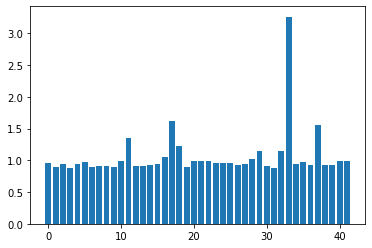

In [6]:
class_weight = compute_class_weight('balanced', np.unique(np.argmax(train_label, axis=1)), np.argmax(train_label, axis=1))
plt.bar(range(42), class_weight)

(871, 871, 3)


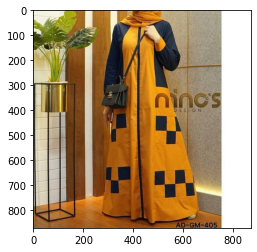

In [7]:
img = cv2.imread('../input/shopee-product-detection-open/train/train/train/00/00b32bd5ba9cdd7c2f11e3975b3e54fa.jpg')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [9]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((train_path, train_label))
    .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# valid_dataset = (
#     tf.data.TFRecordDataset
#     .from_tensor_slices((valid_path, valid_label))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment, num_parallel_calls=AUTO)
#     .cache()
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(test_path)
    .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

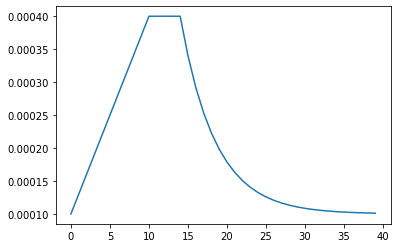

In [10]:
EPOCHS = 40
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn)

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [11]:
!pip install -q efficientnet

In [12]:
from efficientnet.tfkeras import EfficientNetB3

with strategy.scope():
    efn = EfficientNetB3(include_top=False, weights='noisy-student', pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = Sequential()
    model.add(efn)
    model.add(L.Dense(42, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

43933696/43933088 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1536)              10783528  
_________________________________________________________________
dense (Dense)                (None, 42)                64554     
Total params: 10,848,082
Trainable params: 10,760,786
Non-trainable params: 87,296
_________________________________________________________________
None


In [13]:
mc = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True, save_weights_only=True)
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[lr, mc], steps_per_epoch=train_label.shape[0] // BATCH_SIZE)

Epoch 1/40
156/156 [==============================] - 549s 4s/step - accuracy: 0.4393 - loss: 2.4094 - lr: 1.0000e-04
Epoch 2/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.6905 - loss: 1.1775 - lr: 1.3000e-04
Epoch 3/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.7568 - loss: 0.9015 - lr: 1.6000e-04
Epoch 4/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.7949 - loss: 0.7385 - lr: 1.9000e-04
Epoch 5/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.8286 - loss: 0.6049 - lr: 2.2000e-04
Epoch 6/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.8570 - loss: 0.4946 - lr: 2.5000e-04
Epoch 7/40
156/156 [==============================] - 26s 167ms/step - accuracy: 0.8851 - loss: 0.3979 - lr: 2.8000e-04
Epoch 8/40
156/156 [==============================] - 26s 168ms/step - accuracy: 0.8995 - loss: 0.3260 - lr: 3.1000e-04
Epoch 9/40
156/156 [======================

KeyboardInterrupt: 

In [14]:
with strategy.scope():
    model.load_weights('weights.h5')
# valid_prob = model.predict(valid_dataset, verbose=1)
# print(metrics.classification_report(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))
# print(metrics.confusion_matrix(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))

In [15]:
preds = model.predict_classes(test_dataset, verbose=1)
test.loc[:, 'category'] = preds
test.to_csv('submission.csv', index=False)
test.head()

96/96 [==============================] - 364s 4s/step


,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,41
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,4
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [ ]:
img = cv2.imread('../input/shopee-product-detection-open/test/test/test/127f3e6d6e3491b2459812353f33a913.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))